# Necessary Module Imports

In [51]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr

# Data Preprocessing and Excel File Handling

## Constants

In [52]:
number_qubits = 10

## Read in the Excel File

In [53]:
# The file that holds the results from the local, remote, and quantum runs
file_path = "ghz_10_merged_updated.xlsx"  # replace with full path if needed
# Read the Excel file
df = pd.read_excel(file_path, dtype={'Binary': str})

In [54]:
print(df)

      Run         Source      Binary  Count
0       0          local  0000000000   1669
1       0          local  0000000001     70
2       0          local  0000000010     31
3       0          local  0000000011     10
4       0          local  0000000100    181
...   ...            ...         ...    ...
6929    9  torino_remote  1111111011     48
6930    9  torino_remote  1111111100     14
6931    9  torino_remote  1111111101     62
6932    9  torino_remote  1111111110    208
6933    9  torino_remote  1111111111   1389

[6934 rows x 4 columns]


## Process the `DataFrame`

This is done by:

- Grouping the data by `'Source'` and `'Binary'`
- Compensating for any missing states by padding with zeros
- Calculating the mean, probability, variance, and standard deviation for each group
- Converting the processed data into a new `DataFrame`


In [55]:
# Step 1: Generate all possible 10-bit states
all_states = [''.join(bits) for bits in itertools.product('01', repeat=10)]

# Step 2: Get all unique sources
unique_sources = df['Source'].unique()

# Step 3: Group the data
groupedData = df.groupby(['Source', 'Binary'])['Count']

# Step 4: Convert existing groups to a set of present keys
existing_keys = set(groupedData.groups.keys())

# Step 5: Process all Source × Bitstring pairs
processed_df_list = []

for source in unique_sources:
    for bitstring in all_states:
        key = (source, bitstring)
        if key in existing_keys:
            x = groupedData.get_group(key).values.tolist()
        else:
            x = [0] * 10  # Fill missing with zeros

        if len(x) < 10:
            x += [0] * (10 - len(x))  # Pad if needed

        count_array = np.array(x)
        processed_df_list.append({
            'Source': source,
            'Bitstring': bitstring,
            'Mean': np.mean(count_array),
            'Probability': np.mean(count_array) / 4096,
            'Variance': np.var(count_array),
            'StdDev': np.std(count_array),
            'MissingValues': 10 - len(x) if key in existing_keys else 10,
            'RawTotal': np.sum(count_array),
            'RawValues': x
        })

# Step 6: Final DataFrame
processed_df = pd.DataFrame(processed_df_list)
complete_df = processed_df

In [56]:
processed_df.to_excel("output.xlsx", index=False)

##  Now, we compare the data as groups based on the bitstrings:
 - The data is grouped into bitstring groups.
 - Each one will have 6 elements - one for each source.
 - We will then average each bitstring, and pick the 3-5 most occuring ones,
    - These will form the basis for data analysis.
    - The others will be analysed for a general understanding/comparison between local and remote.
 - Then, the relavent rows of the dataframe will be passed to plot things like a box and whisker plot.

In [57]:
groupedData = complete_df.groupby(['Bitstring'])
average_mean_array = []
for group_name, group_df in groupedData:
    # print(f"Processing group: {group_name} - Data: \n{group_df}")
    
    bitstring_name = group_df['Bitstring'].values[0]
    average_mean = group_df['Mean'].mean()
    # print(f"Bitstring {bitstring_name} with mean: {average_mean}")
    average_mean_array.append([bitstring_name, average_mean])

sorted_mean_array = sorted_data = sorted(average_mean_array, key=lambda x: x[1], reverse=True)
selected_states = [pair[0] for pair in sorted_mean_array[0:5]]
print(selected_states)
if len(sorted_mean_array) == 2**number_qubits:
    print("All Elements Accounted For")

['0000000000', '1111111111', '0000000001', '1111111110', '1111111011']
All Elements Accounted For


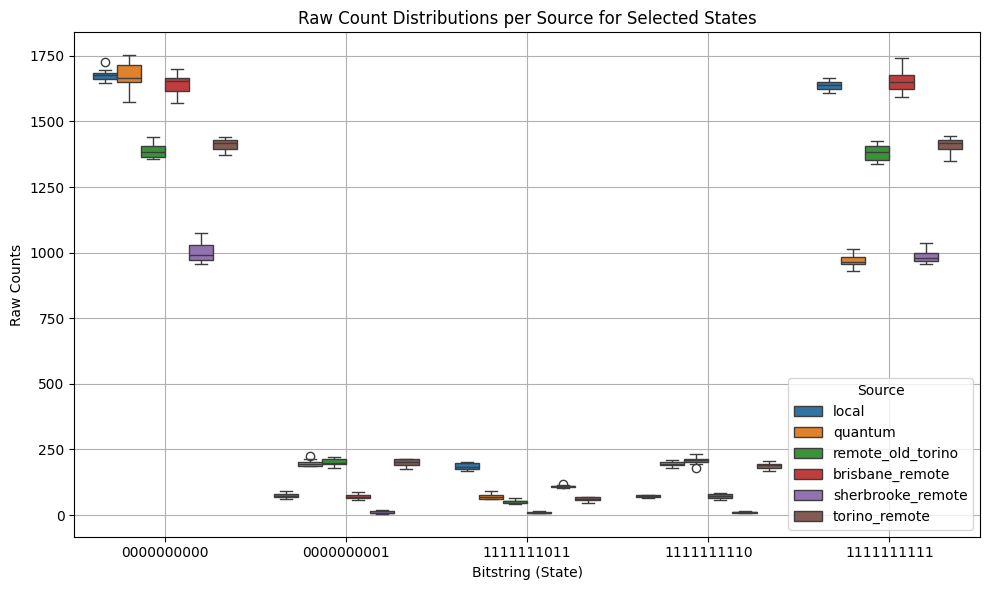

In [58]:
def plot_data(selected_states, complete_df, show_debug=False):
    """
    Plot box-and-whisker plots of RawValues for each selected bitstring,
    grouped by Source.

    Parameters:
    - selected_states: List of bitstrings (e.g., ['0000011111', '0000011110'])
    - complete_df: The full DataFrame containing 'Bitstring', 'Source', 'RawValues'
    - show_debug: If True, prints raw grouped data before plotting
    """

    # Filter to only selected bitstrings
    plotting_df = complete_df[complete_df['Bitstring'].isin(selected_states)].copy()

    # Debug output: print grouped data
    if show_debug:
        grouped = plotting_df.groupby('Bitstring')
        for group_name, group_df in grouped:
            print(f"\nProcessing group: {group_name} - Data:\n{group_df}")

    # Ensure RawValues is a list (parse if stored as string)
    plotting_df['RawValues'] = plotting_df['RawValues'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    # Explode the list of RawValues into separate rows
    exploded_df = plotting_df.explode('RawValues')
    exploded_df['RawValues'] = exploded_df['RawValues'].astype(float)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=exploded_df, x='Bitstring', y='RawValues', hue='Source')
    plt.title("Raw Count Distributions per Source for Selected States")
    plt.xlabel("Bitstring (State)")
    plt.ylabel("Raw Counts")
    plt.legend(title="Source")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_data(selected_states, complete_df, show_debug=False)

## Compute Divergence Parameters

In [59]:
def js_divergence(p, q, base=2):
    """
    Calculate Jensen-Shannon divergence between two probability distributions.
    
    Returns a value between 0 and 1.
    """
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

    # Normalize to make sure they're valid probability distributions
    p /= p.sum()
    q /= q.sum()

    js = jensenshannon(p, q, base=base)  # returns sqrt(JS)
    return js**2  # return actual JS divergence

def kl_divergence(p, q):
    """
    Calculate Kullback-Leibler divergence from p to q: D_KL(p || q).
    
    Note: p and q must be the same length and have no zero in q where p is non-zero.
    """
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

    # Normalize to ensure probabilities
    p /= p.sum()
    q /= q.sum()

    # Smooth to avoid log(0) and division by 0
    eps = 1e-12
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)

    return np.sum(rel_entr(p, q))  # = sum(p * log(p / q))

def divergence_prep(complete_df):
    groupedData = complete_df.groupby(['Source'])['Mean']
    distribution = []
    for n, d in groupedData:
        distribution.append([n, d.values.tolist()])

    print("Running KL Analysis")
    for i in range(len(distribution)):
        if i != 2 and i != 3: # This is the set for the quantum computer.
            print(f"KL - Source: {distribution[i][0]} compared with {distribution[2][0]} Result: {kl_divergence(distribution[i][1], distribution[2][1])}")
            
    print("Running JS Analysis")
    for i in range(len(distribution)):
        if i != 2 and i != 3: # This is the set for the quantum computer.
            print(f"JS - Source: {distribution[i][0]} compared with {distribution[2][0]} Result: {js_divergence(distribution[i][1], distribution[2][1])}")
            

    return 0

divergence_prep(complete_df)

Running KL Analysis
KL - Source: ('brisbane_remote',) compared with ('quantum',) Result: 0.27067656954511654
KL - Source: ('local',) compared with ('quantum',) Result: 0.2924737468151833
KL - Source: ('sherbrooke_remote',) compared with ('quantum',) Result: 1.2341096844360941
KL - Source: ('torino_remote',) compared with ('quantum',) Result: 0.19133146429218484
Running JS Analysis
JS - Source: ('brisbane_remote',) compared with ('quantum',) Result: 0.0963896978970321
JS - Source: ('local',) compared with ('quantum',) Result: 0.11791369055986121
JS - Source: ('sherbrooke_remote',) compared with ('quantum',) Result: 0.2018479842368083
JS - Source: ('torino_remote',) compared with ('quantum',) Result: 0.05153356317825912


0